# Finding issues in consensus sequences

All functions in this notebook will be available after version 0.1.12! 

After building the consensus sequences using `Verkko`, some assembly errors may remain, such as switching errors. Some of these errors can be corrected by revisiting the graph and identifying incorrect paths. However, the difference in data formats between the final consensus FASTA and the graph makes this step challenging. The final consensus sequence is in FASTA format and is not homopolymer-compressed(HPC), unlike the graph. In this Jupyter notebook, we provide a way to convert the coordinates of a region of interest from the FASTA sequence to the corresponding nodes in the graph, and vice versa.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



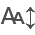

/path/to/your/folder/script/test_notebooks/basics
verkko-fillet version:0.1.12
verkko-fillet version:0.1.12


In [4]:
%load_ext autoreload
%autoreload 2

import sys 
import importlib
import pandas as pd
import time
import os
from IPython.display import Image, display
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import warnings
import session_info
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tqdm
from importlib import reload
print(os.getcwd())
sys.path.append('/data/Phillippy/projects/giraffeT2T/assembly/script/verkko-fillet/src')
import verkkofillet as vf
vf = reload(vf)

In [25]:
import verkkofillet as vf

## Trace back from un-HPC sequence to corresponding nodes in HPC graph

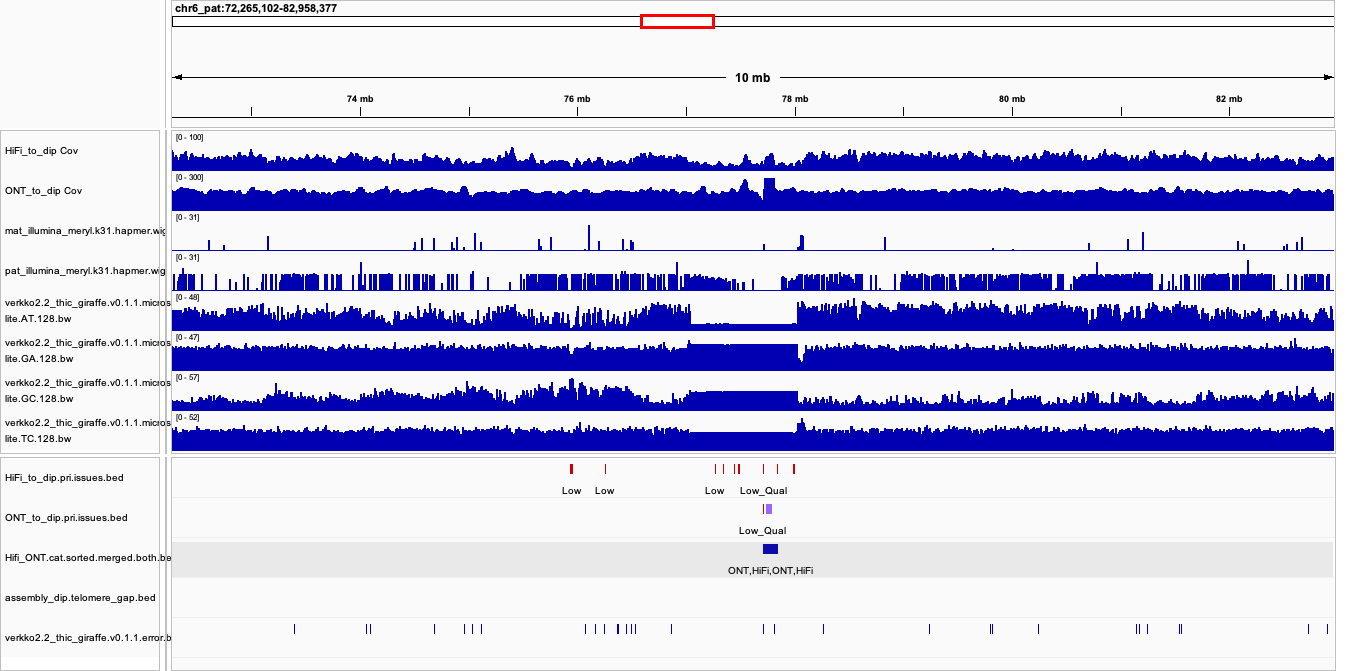

In [18]:
display(Image(filename="../image/igv_snapshot.png",width=1200))

Here is an example on chr6_pat in Giraffe, shown in the middle of the IGV screenshot. Both alignment patterns have issues. Let's identify which nodes are involved in this region and check if it is one of the regions where we filled a gap.

We use a BED file containing all the intersected issues from both HiFi and ONT alignments. For more details, you can check [marbl training material](https://github.com/marbl/training/tree/main/part3-evaluate). Additionally, we will add padding regions at both ends of each region in the BED file.

In [ ]:
# issue region
bed_file = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/issues/Hifi_ONT.cat.sorted.merged.both.bed"
fai = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet/assembly_trimmed_flipped_rename_sortedhap.fasta.fai"

vf.tl.addPadding_to_bed(bed_file , fai, force = True)

Force mode is enabled. Existing output files will be overwritten.
Saving padded BED file to /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/issues/Hifi_ONT.cat.sorted.merged.both.pad_10000.bed, with adding 10000 padding to the start and end positions.


Next, we will generate a JSON map file linking the coordinates between the un-HPC FASTA and the HPC FASTA. This process is performed using the following command and may take a long time to complete:

In [ ]:
# input 
uncomp_fasta = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet/assembly_trimmed_flipped_rename_sortedhap.fasta"

# output
mapJson_file = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/findNodes/map.json"

vf.tl.build_sparse_compression_map(uncomp_fasta, mapJson_file=mapJson_file)

`build_sparse_compression_map` will generate a map.json file, which will be used in the next step to liftover the regions. 
By default, the output file name has the same name as the input FASTA file with the suffix `.map.json`. If you want to specify a custom file name, you can do so manually.
For the BED file, this step may take a long time, so it is recommended to filter for regions of interest. Here, we have filtered only the primary contigs.

In [ ]:
# input
uncomp_bed= "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/issues/Hifi_ONT.cat.sorted.merged.both.pad_10000.filtered.bed"

# output
comp_bed= "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/issues/Hifi_ONT.cat.sorted.merged.both.pad_10000.filtered.comp.bed"

vf.tl.lift_seqs(uncomp_fasta, mapJson_file, uncomp_bed)

After lifting over to HPC coordinates, the regions in the BED file can be processed using `vf.pp.bed_to_regionList` function.
This function returns a list of regions, where The list follows the format: 'chr:start-end'

In [10]:
regions_list = vf.pp.bed_to_regionsList(comp_bed)
regions_list[0:3]

['chr10_pat:11151143-11173573',
 'chr10_pat:31856658-31882613',
 'chr10_pat:109598646-109618946']

In [11]:
gaf_file = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/graphaligner_assembly_dip_with_cigar.gaf"
graph_file = "/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_gapFilling/assembly.homopolymer-compressed.noseq.gfa"

finalnodes = vf.pp.getNodes_from_unHPCregion(gaf_file, graph_file, regions_list)

Finding nodes for regions: 100%|██████████| 33/33 [00:03<00:00,  8.25it/s]


In [12]:
finalnodes

region  \
0     chr10_pat:11151143-11173573   
1     chr10_pat:31856658-31882613   
2   chr10_pat:109598646-109618946   
3     chr11_mat:31486037-31517034   
4     chr11_mat:49437904-50014607   
5     chr11_mat:50043039-50190314   
6     chr11_mat:50240589-50617374   
7     chr11_mat:69244526-69384148   
8     chr11_pat:48869998-49226786   
9     chr11_pat:49858668-50032389   
10    chr11_pat:68132626-68264115   
11    chr13_pat:31715512-31790695   
12      chr14_mat:6130950-6155055   
13      chr14_mat:9138326-9492178   
14      chr14_mat:9662828-9832934   
15     chr14_mat:9843378-10548750   
16      chr14_pat:8194836-8383018   
17     chr1_pat:78598923-78642225   
18     chr1_pat:79628125-79719470   
19       chr4_pat:1340596-1361213   
20   chr5_mat:131675494-131697701   
21     chr6_pat:54815981-54929325   
22       chr7_mat:3001574-3021474   
23     chr7_mat:45803055-45832666   
24     chr8_pat:28722405-28781934   
25     chr8_pat:48171912-48377627   
26     chr9_mat:39536594-39593470   
27     chr9_mat:57607624-57659167   
28     chr9_mat:57680824-57761812   
29     chr9_pat:39387663-39442148   
30     chr9_pat:58618440-58760537   
31   chrX_mat:104327434-104347024   
32         chrY_pat:616197-636568   

                                                nodes  
0                                        [utig4-2061]  
1       [utig4-487, utig4-482, utig4-484, utig4-1849]  
2                                         [utig4-291]  
3                                         [utig4-564]  
4   [utig4-98, utig4-99, utig4-96, utig4-100, utig...  
5                  [utig4-2421, utig4-495, utig4-100]  
6                             [utig4-2421, utig4-495]  
7   [utig4-1083, utig4-334, utig4-331, utig4-1087,...  
8                                          [utig4-69]  
9                             [utig4-2421, utig4-496]  
10  [utig4-1084, utig4-334, utig4-331, utig4-1088,...  
11   [utig4-1437, utig4-1439, utig4-1442, utig4-2673]  
12                                          [utig4-5]  
13                    [utig4-207, utig4-210, utig4-5]  
14                                        [utig4-151]  
15                           [utig4-1729, utig4-1730]  
16   [utig4-2737, utig4-2725, utig4-2732, utig4-2748]  
17               [utig4-1751, utig4-1750, utig4-1997]  
18               [utig4-1575, utig4-1576, utig4-1574]  
19                                       [utig4-1638]  
20                                       [utig4-2460]  
21                           [utig4-2329, utig4-2651]  
22                                          [utig4-1]  
23       [utig4-49, utig4-2498, utig4-45, utig4-2499]  
24               [utig4-2469, utig4-2198, utig4-2199]  
25                           [utig4-2514, utig4-2516]  
26     [utig4-2208, utig4-460, utig4-2210, utig4-459]  
27   [utig4-2295, utig4-1366, utig4-1365, utig4-2297]  
28               [utig4-1578, utig4-1366, utig4-1365]  
29     [utig4-2208, utig4-460, utig4-2210, utig4-459]  
30  [utig4-1578, utig4-2295, utig4-1583, utig4-158...  
31                                       [utig4-1999]  
32                                       [utig4-1627]

In the example above, the region `chr6_pat:54815981-54929325` is matched with `[utig4-2329, utig4-2651]`. We can observe that this region is one of the manually gap-filled regions where we introduced new nodes to the graph to connect unconnected nodes using ONT reads.

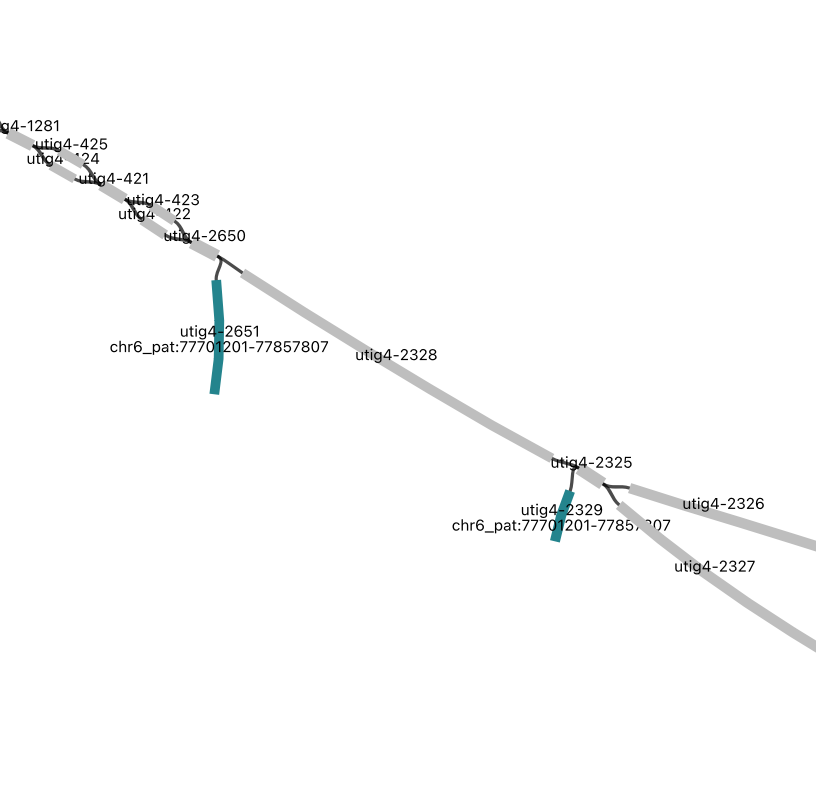

In [19]:
display(Image(filename="../image/graphchr6.png",width=500))

Now, you can save the `finalnodes` DataFrame locally to use it in the next step.
Alternatively, we can use the `vf.tl.make_bandage_csv` function to create a CSV file that can be used in Bandage to visualize the final nodes.
The final file will have the following columns:

* `node`: Node name
* `uncomp`: Position of the node in the uncompressed FASTA
* `comp`: Position of the node in the compressed FASTA

In [ ]:
vf.tl.make_bandage_csv(finalnodes, uncomp_bed, comp_bed, force = True)

Force mode is enabled. Existing output files will be overwritten.
writing to /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/issues/Hifi_ONT.cat.sorted.merged.both.pad_10000.filtered.comp.csv


# Find Specific regions on nodes

There may be cases where a clear haplotype switch error occurs in the middle of a large node rather than at the junction of nodes.

If you need to locate a specific region within a node, you can use the following code to identify the region.

## assign haplotype to each reads using merly

In [5]:
file = '/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/hifi.read.meryl.hapAssign.txt'
hifi_read = vf.pp.read_hapAssignRead(file)
hifi_read.head()

read  len_read  hap1_total_kmer  \
0  m84124_230731_175605_s1/251662659/ccs      3553         37089377   
1  m84124_230731_175605_s1/234884948/ccs      3049         37089377   
2  m84124_230731_175605_s1/251663502/ccs     11636         37089377   
3  m84124_230731_175605_s1/257297513/ccs     17014         37089377   
4  m84124_230731_175605_s1/234885062/ccs     18934         37089377   

   hap1_found_kmer  hap2_total_kmer  hap2_found_kmer    hap_read  
0                0         36898822                0  Unassigned  
1                0         36898822                0  Unassigned  
2                0         36898822                0  Unassigned  
3              158         36898822                0        hap1  
4               20         36898822                0        hap1

## Read layout and scfmap for each node

In [6]:
mainDir = '/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic'

obj = vf.pp.read_Verkko(mainDir)
os.chdir(mainDir)

The Verkko fillet target directory already exists: /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet
If you didn't mean this, please set another directory or for overwirting, please use force= True
Lock the original Verkko folder to prevent it from being modified.
[lock_original_folder] Command executed successfully!
Path file loading...from /path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_verkko_fillet/assembly.paths.tsv
Path file loaded successfully.
scfmap file not found or path is None.


In [7]:
nodeinfo, node_layout,node_layout_idx= vf.pp.readNodeInfo()

print(nodeinfo.head())

print(node_layout.head())

print(node_layout_idx.head())

         node    mat    pat    mat:pat    color hap_node      len        piece
0     utig4-0      0      0        0:0  #AAAAAA   lowcov    91826  piece000001
1     utig4-1  59053    342  59053:342  #FF8888      mat  1586764  piece000002
2    utig4-10      0    527      0:527  #8888FF      pat    19952  piece000011
3   utig4-100    627      0      627:0  #FF8888      mat   393691  piece000101
4  utig4-1000      1  14336    1:14336  #8888FF      pat   413025  piece001001
                                         layout_info
0                                   tig\tpiece000001
1                                        len\t205259
2                                             trm\t0
3                                           rds\t860
4  3a15d69c-9360-42ca-9e19-042b77c18780;b25fd07b-...
   index        piece
0      0  piece000001
1    865  piece000002
2   6585  piece000003
3  12296  piece000004
4  24709  piece000005


In [8]:
gaf = '/path/to/your/folder/verkko2.2_hifi-duplex_trio-hic/verkko-thic_v0.1.0_verkko_fillet_polishing/graphaligner_assembly_dip_with_cigar.gaf'
graph = "assembly.homopolymer-compressed.noseq.gfa"
region = ['chr10_pat:11151143-11173573', 'chr10_mat:1943373-10400000']

regions_node_db, regions_node_coor = vf.pp.getNodes_from_unHPCregion(gaf, graph, region)

print(regions_node_db)

print(regions_node_coor)


Finding nodes for regions: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                        region                                 nodes
0  chr10_pat:11151143-11173573                          [utig4-2061]
1   chr10_mat:1943373-10400000  [utig4-1795, utig4-2059, utig4-2060]
         node  start_coor_path_comp  end_coor_path_comp  len_node  \
0  utig4-2061              10165055            11264668   1099613   
1  utig4-1795                  7607            10089484  10081877   
2  utig4-2059              10087816            10246152    158336   
3  utig4-2060              10244708            11344067   1099359   

   start_coor_on_node  end_coor_on_node                       region  
0              982859           1099613  chr10_pat:11151143-11173573  
1             1936147            310897   chr10_mat:1943373-10400000  
2                   0            154229   chr10_mat:1943373-10400000  
3                   0           1099359   chr10_mat:1943373-10400000  


In [9]:
loc_on_node, mergedb_all = vf.pp.getNodeCoor(obj, regions_node_db, hifi_read, node_layout, node_layout_idx, nodeinfo, regions_node_coor)

print(loc_on_node)

print(mergedb_all)

regions of interest: 100%|██████████| 2/2 [00:32<00:00, 16.44s/it]

         node                       region  \
0  utig4-2061  chr10_pat:11151143-11173573   
0  utig4-1795   chr10_mat:1943373-10400000   
0  utig4-2059   chr10_mat:1943373-10400000   
0  utig4-2060   chr10_mat:1943373-10400000   

                                       contig    start      end hap_node  
0  sire_compressed.k31.hapmer_from_utig4-1316   982859  1099613      pat  
0   dam_compressed.k31.hapmer_from_utig4-1315  1936147   310897      mat  
0   dam_compressed.k31.hapmer_from_utig4-1315        0   154229   lowcov  
0   dam_compressed.k31.hapmer_from_utig4-1315        0  1099359      mat  
                                                   read  len_read  \
0     44af7e69-5ecd-4c1f-8003-261aab21c883;a74bfbd1-...   79710.0   
1                 m84124_231207_000930_s3/124455843/ccs   34289.0   
2     bc98aa1a-5d1f-4dfd-93c8-2fbda885000f;94cfbd16-...  123230.0   
3                 m84124_230818_165616_s1/210177320/ccs   20133.0   
4                  m84124_230828_171016_s1/521723

In [10]:
hap_dict = dict({'hap1': 'mat',
                 'hap2': 'pat',
                 'Unassigned' : 'Unassigned'})
mergedb_all['hap_read'] = mergedb_all['hap_read'].map(hap_dict)
mergedb_all.groupby('hap_read').size()

hap_read
Unassigned     7667
mat           31992
pat            4630
dtype: int64

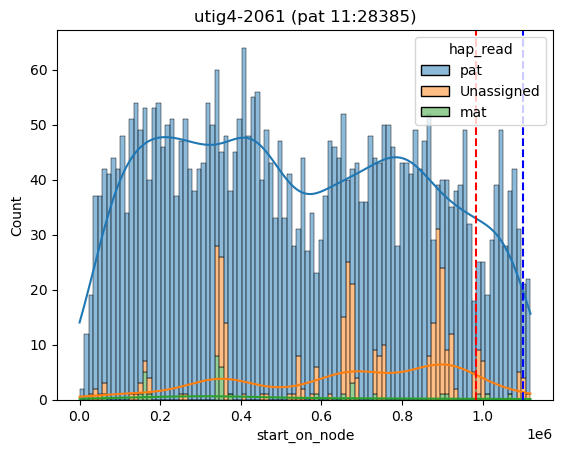

In [11]:
node = 'utig4-2061'
vf.pl.plotHist_readOnNode(nodeinfo, mergedb_all, loc_on_node, node, hue = "hap_read", 
                          x = "start_on_node",
                          multiple = 'stack',
                          )

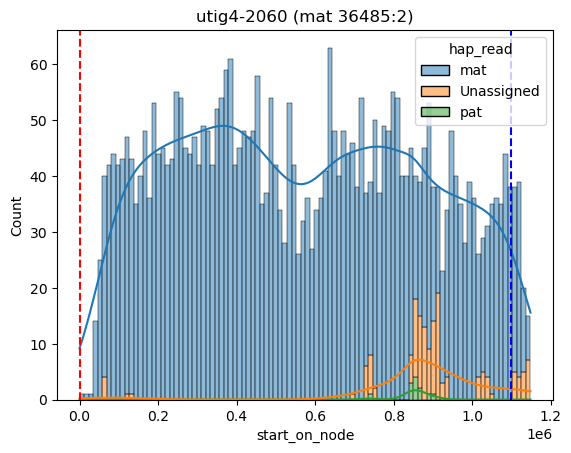

In [12]:
node = 'utig4-2060'
vf.pl.plotHist_readOnNode(nodeinfo, mergedb_all, loc_on_node, node, hue = "hap_read", 
                          x = "start_on_node",
                          # x = "mid_on_node",
                          multiple = 'stack',
                          )

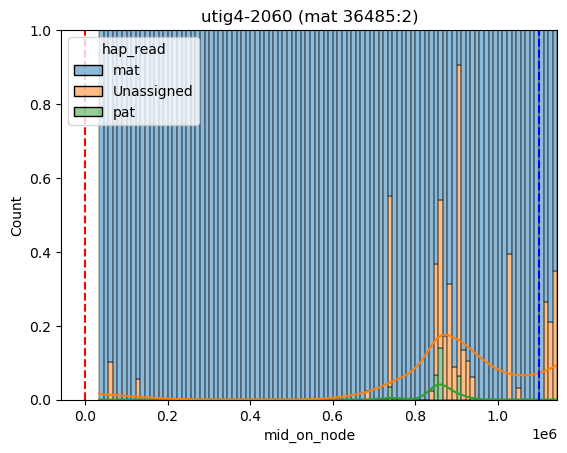

In [13]:
vf.pl.plotHist_readOnNode(nodeinfo, mergedb_all, loc_on_node, node, hue = "hap_read", x = "mid_on_node", multiple = 'fill')

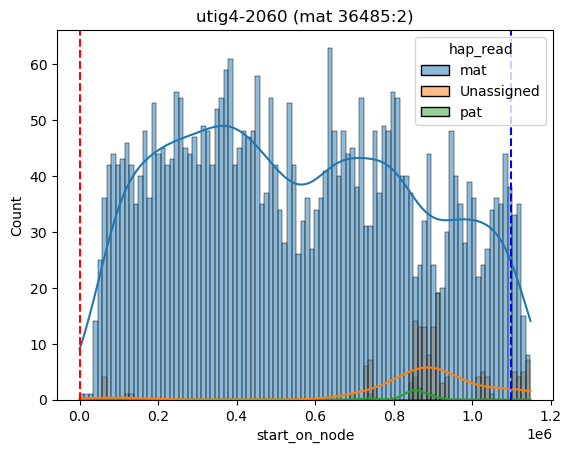

In [14]:
vf.pl.plotHist_readOnNode(nodeinfo, mergedb_all, loc_on_node, node, hue = "hap_read", x = "start_on_node")

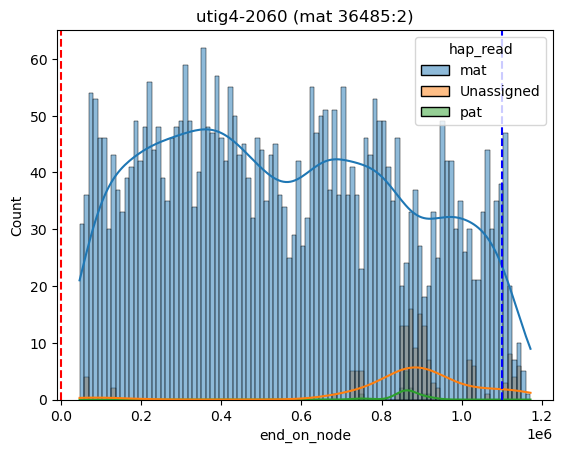

In [15]:
vf.pl.plotHist_readOnNode(nodeinfo, mergedb_all, loc_on_node, node, hue = "hap_read", x = "end_on_node")

In [16]:
exc_read_db = mergedb_all.copy()
exc_read_db['exc'] = "Y"
exc_read_db.loc[exc_read_db['hap_read'] == exc_read_db['hap_node'], 'exc'] = "N"
exc_read_db.loc[exc_read_db['hap_read'] == 'Unassigned', 'exc'] = "N"
exc_read_db = exc_read_db[exc_read_db['exc'] == 'Y']
exc_read_db.to_csv(f"../exc_read_db.csv", index=False)

In [17]:
obj = vf.pp.findGaps(obj)

45 gaps were found -> obj.gaps


In [18]:
segment, link = vf.pp.readGraph('assembly.homopolymer-compressed.noseq.gfa')
node_space = vf.pp.getNodeSpace_from_allPath(obj, segment, link, file = '../comp_node.bed')

100%|██████████| 366/366 [00:05<00:00, 67.60it/s] 


In [19]:
sub = node_space.loc[node_space['chrom'] == 'dam_compressed.k31.hapmer_from_utig4-1003',:]
sub['nodeLen'] = sub['chromEnd'] - sub['chromStart']
sub

chrom  chromStart   chromEnd  \
0    dam_compressed.k31.hapmer_from_utig4-1003           0    8783134   
1    dam_compressed.k31.hapmer_from_utig4-1003     8781613    8889873   
2    dam_compressed.k31.hapmer_from_utig4-1003     8888273   14718290   
3    dam_compressed.k31.hapmer_from_utig4-1003    14716651   14794732   
4    dam_compressed.k31.hapmer_from_utig4-1003    14793239   19606446   
..                                         ...         ...        ...   
104  dam_compressed.k31.hapmer_from_utig4-1003   123625356  124182922   
105  dam_compressed.k31.hapmer_from_utig4-1003   124181375  124263124   
106  dam_compressed.k31.hapmer_from_utig4-1003   124261476  127786383   
107  dam_compressed.k31.hapmer_from_utig4-1003   127784904  127857502   
108  dam_compressed.k31.hapmer_from_utig4-1003   127855875  137059345   

           name  score strand  nodeLen  
0    utig4-1913    100      -  8783134  
1    utig4-1911    100      -   108260  
2    utig4-1693    100      -  5830017  
3    utig4-1692    100      +    78081  
4    utig4-1695    100      +  4813207  
..          ...    ...    ...      ...  
104   utig4-175    100      -   557566  
105   utig4-171    100      -    81749  
106   utig4-172    100      +  3524907  
107  utig4-2458    100      +    72598  
108  utig4-2460    100      +  9203470  

[109 rows x 7 columns]

In [20]:
sub = sub.merge(nodeinfo , left_on = 'name', right_on = 'node', how = 'left')
sub.loc[sub['nodeLen'] != sub['len'], :]

chrom  chromStart  chromEnd  \
49  dam_compressed.k31.hapmer_from_utig4-1003    71776654  71781654   

                   name  score strand  nodeLen node  mat  pat mat:pat color  \
49  [N5000N:ambig_path]    100      .     5000  NaN  NaN  NaN     NaN   NaN   

   hap_node  len piece  
49      NaN  NaN   NaN

In [21]:
node_space.groupby('chrom').max('chromEnd')

chromStart   chromEnd  score
chrom                                                                   
dam_compressed.k31.hapmer_from_utig4-1003    127855875  137059345    100
dam_compressed.k31.hapmer_from_utig4-1104    106474986  106942458    100
dam_compressed.k31.hapmer_from_utig4-1243    163366629  168480767    100
dam_compressed.k31.hapmer_from_utig4-1282    123741232  126323570    100
dam_compressed.k31.hapmer_from_utig4-1315    101717951  114142144    100
...                                                ...        ...    ...
sire_compressed.k31.hapmer_unused_utig4-86           0      15764    100
sire_compressed.k31.hapmer_unused_utig4-9            0      17738    100
sire_compressed.k31.hapmer_unused_utig4-92           0      39453    100
sire_compressed.k31.hapmer_unused_utig4-94           0      33823    100
sire_compressed.k31.hapmer_unused_utig4-95           0      29333    100

[366 rows x 3 columns]